# These codes are direct replication of calculations in the article

### Loading data

In [ ]:
#%pip install -e .. 

#Import the package
import implicitquotas as iq 

# Import other useful packages for this demonstration
import pandas as pd
import numpy as np
from scipy.stats import binom
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from pathlib import Path
from scipy import stats

In [2]:
# ─── CONSTANTS ────────────────────────────────────────────────────────────────
SAVE_DIRECTORY = r"..\output"

# Where to find the CSV with the data, for example:
DATA_PATH = Path(r"..\data\data.csv")

In [3]:
# This is synthetic data generated for the purposes of demonstration
df = pd.read_csv(DATA_PATH) 


### Cleaning data - creating takers samples

In [ ]:
# group values to drop:
DROP_GROUP = {"T", "U", "O", "B"}
# Countries to keep:
KEEP_COUNTRIES = {
    "AUSTRIA", "BELGIUM", "BULGARIA", "CZECH", "DENMARK", "ESTONIA", "FINLAND",
    "FRANCE", "GERMANY", "GREECE", "HUNGARY", "ICELAND", "ITALY", "LATVIA",
    "NORWAY", "POLAND", "PORTUGAL", "RUSSIA", "SLOVAKIA", "SPAIN", "SWEDEN",
    "SWITZERLAND", "UK"
}

# Year cutoff:
MIN_YEAR = 2000 # 2020 

# Columns to convert to pandas' Nullable Integer (Int64) at the end:
INT_COLUMNS = ["W", "M"]

# ─── LOADING + INITIAL FILTERING ─────────────────────────────────────────────

# 1) Read
df = pd.read_csv(DATA_PATH)

# 2) Keep
mask = (
    (~df["group"].isin(DROP_GROUP))
    & (df["country"].isin(KEEP_COUNTRIES))
    & (df["year"] >= MIN_YEAR)
)
df_base = df.loc[mask] #.copy()
del df  

# ─── HELPER FUNCTION FOR SUBSET CREATION ───────────────────────────────────────

def filter_by_threshold_year(
    base_df: pd.DataFrame, threshold: int
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    1) Keep only rows where base_df['total'] >= threshold.
    2) Call that result `subset_all`.
    3) Within subset_all, compute for each (id, country) the sum of W.
       - If sum == 0, mark the entire row as “never‐taker” for that firm.
       - Keep only rows where sum(W) > 0 → call that `subset_takers`.
    Returns: (subset_all, subset_takers)
    """
    # (1) Year‐by‐year filter
    subset_all = base_df.loc[base_df["total"].ge(threshold)].copy()

    # (2) For each firm‐country, sum W across subset_all
    fem_sum = (
        subset_all
        .groupby(["id", "country"])["W"]
        .transform("sum")
    )

    # (3) Keep only those rows where sum(W) > 0
    subset_takers = subset_all.loc[fem_sum.gt(0)].copy()
    return subset_all, subset_takers


def filter_by_threshold_ever(
    base_df: pd.DataFrame, threshold: int
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    1) Find all (id, country) pairs whose MAX(total) >= threshold at any year.
       - Call that boolean Series `firms_ever`.
    2) Keep ALL rows (all years) for those firms → call that `subset_all`.
    3) Within subset_all, compute sum of W per (id, country).
       - If sum == 0, they never had any female board seats in any year (in this subset).
       - Call those “never-takers”; drop them to form `subset_takers`.
    Returns: (subset_all, subset_takers)
    """
    # (1) Which firms ever had boards >= threshold?
    firms_ever = (
        base_df
        .groupby(["id", "country"])["total"]
        .max()
        .ge(threshold)
    )

    # (2) Filter base_df to only those firms (all years)
    idx_firms = base_df.set_index(["id", "country"]).index.isin(
        firms_ever[firms_ever].index
    )
    subset_all = base_df.loc[idx_firms].copy()

    # (3) Now compute sum(W) per firm‐country within subset_all
    fem_sum = (
        subset_all
        .groupby(["id", "country"])["W"]
        .transform("sum")
    )

    subset_takers = subset_all.loc[fem_sum.gt(0)].copy()
    return subset_all, subset_takers


# ─── CREATE THREE PAIRS OF DATAFRAMES ───────────────────────────────────

# 1) dfr2 (yearly >=2) and takers2
dfr2, takers2 = filter_by_threshold_year(df_base, threshold=2)

# 2) dfr3 (yearly >=3) and takers3
dfr3, takers3 = filter_by_threshold_year(df_base, threshold=3)

# 3) dfr23 (ever had >=3) and takers23
dfr23, takers23 = filter_by_threshold_ever(df_base, threshold=3)

del df_base  

# Cast W & M in all six DataFrames:
for frame in (dfr2, takers2, dfr3, takers3, dfr23, takers23):
    for col in INT_COLUMNS:
        frame.loc[:, col] = frame[col].astype("Int64")           

In [ ]:
# SES source data
SES_PATH = Path(r"..\data\ses.dta")
SESCY_PATH = Path(r"..\data\ses_cy.dta")

df_ses14 = pd.read_stata(SES_PATH)
df_ses14 = df_ses14.rename(columns = {"nace":"group"})
df_ses14.fem_managers1d = df_ses14.fem_managers1d*100



df_ses14_cy = pd.read_stata(SESCY_PATH)
df_ses14_cy = df_ses14_cy.rename(columns = {"nace":"group"})
df_ses14_cy.fem_managers1d = df_ses14_cy.fem_managers1d*100


dfr23 = pd.merge(dfr23, 
                 df_ses14.rename(columns= {"fem_managers1d": "ps"}),
                  on=["year", "country", "group"],
                  how="left"
                 )

In [9]:
takers23 = pd.merge(takers23, 
                 df_ses14.rename(columns= {"fem_managers1d": "ps"}),
                  on=["year", "country", "group"],
                  how="left"
                 )
takers2 = pd.merge(takers2, 
                 df_ses14.rename(columns= {"fem_managers1d": "ps"}),
                  on=["year", "country", "group"],
                  how="left"
                 )
takers3 = pd.merge(takers3, 
                 df_ses14.rename(columns= {"fem_managers1d": "ps"}),
                  on=["year", "country", "group"],
                  how="left"
                 )

In [11]:
# group by year, country, group, and the (n, m) pair
grouped = (
    dfr2
    .groupby(['year', 'country', 'group', 'W', 'total'])
    .agg(num_firms=('id', 'nunique'))
    .reset_index()
)

In [12]:
# 1) ['year', 'country', 'group']
s1 = dfr23.groupby(['year', 'country', 'group']).size()
kept_3 = s1.ge(15).sum()        # number of groups with ≥15
dropped_3 = s1.lt(15).sum()     # number of groups with <15

print(f"3-level groups kept (≥15): {kept_3}")
print(f"3-level groups dropped (<15): {dropped_3}")

# 2) ['year', 'country']
s2 = dfr23.groupby(['year', 'country']).size()
kept_2 = s2.ge(15).sum()
dropped_2 = s2.lt(15).sum()

print(f"2-level groups kept (≥15): {kept_2}")
print(f"2-level groups dropped (<15): {dropped_2}")

3-level groups kept (≥15): 7345
3-level groups dropped (<15): 595
2-level groups kept (≥15): 473
2-level groups dropped (<15): 7


### Basic statistics about the data

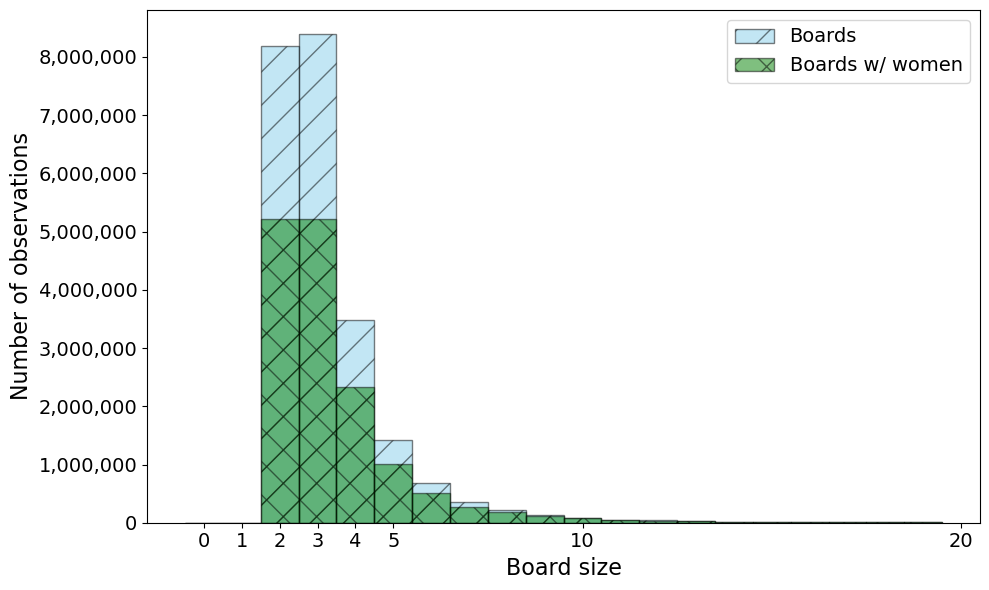

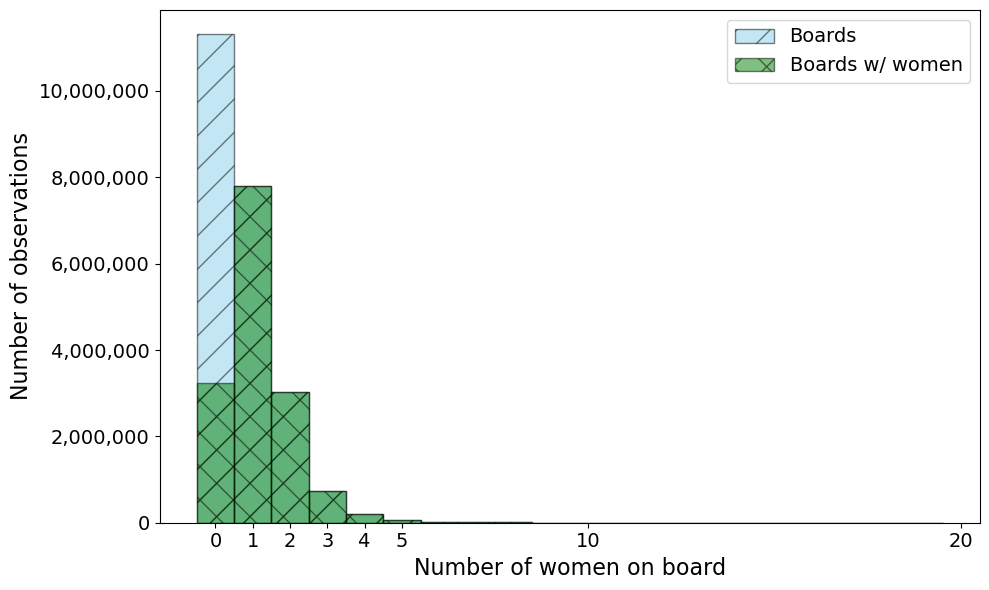

In [ ]:
import os
def plot_two_histograms(
    series_a: pd.Series,
    series_b: pd.Series,
    bins: np.ndarray,
    xlabel: str,
    label_a: str,
    label_b: str,
    save_path: str,
    figsize: tuple[int, int] = (10, 6),
    color_a: str = "skyblue",
    color_b: str = "green",
    alpha: float = 0.5,
    edgecolor: str = "black",
    custom_xticks: list[int] | None = None,
):
    """
    Plot two overlapping histograms (series_a vs. series_b) on the same axes,
    format the y–axis with commas, apply custom x–ticks, and save to disk.

    Parameters
    ----------
    series_a : pd.Series
        The first data series (e.g. dfr['total'] or dfr['W']).
    series_b : pd.Series
        The second data series (e.g. takers['total'] or takers['W']).
    bins : np.ndarray
        The array of bin edges (e.g. np.arange(0, 21) for bins 0..20).
    xlabel : str
        The label for the x–axis.
    label_a : str
        Legend label for series_a.
    label_b : str
        Legend label for series_b.
    save_path : str
        Full path (including filename) where the PNG should be written.
    figsize : tuple[int,int], optional
        Figure size, by default (10, 6).
    color_a : str, optional
        Color for the first histogram (series_a), by default "skyblue".
    color_b : str, optional
        Color for the second histogram (series_b), by default "green".
    alpha : float, optional
        Transparency for both histograms, by default 0.5.
    edgecolor : str, optional
        Color of the bin edges, by default "black".
    custom_xticks : list[int] | None, optional
        If provided, will use these exact integer values as x–ticks.
        Must be a subset of `bins`. By default None → place ticks at every bin edge.
    """

    # 1) Create the figure + axis
    plt.figure(figsize=figsize)

    # 2) Y-axis formatter (commas every three digits)
    def y_fmt(x, pos):
        return f"{int(x):,}"
    plt.gca().yaxis.set_major_formatter(FuncFormatter(y_fmt))

    # 3) Plot histograms
    plt.hist(
        series_a.dropna(),
        bins=bins,
        color=color_a,
        edgecolor=edgecolor,
        alpha=alpha,
        label=label_a,
        align="left",
        hatch="/"
    )
    plt.hist(
        series_b.dropna(),
        bins=bins,
        color=color_b,
        edgecolor=edgecolor,
        alpha=alpha,
        label=label_b,
        align="left",
        hatch="x"
    )

    # 4) Axis labels
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel("Number of observations", fontsize=16)

    # 5) Custom X–ticks
    if custom_xticks is None:
        # Default: tick at every integer bin
        tick_locs = bins
        tick_labels = bins
    else:
        # Only place ticks at those bin edges which appear in `custom_xticks`
        tick_locs = [b for b in bins if b in custom_xticks]
        tick_labels = tick_locs

    plt.xticks(tick_locs, tick_labels, fontsize=14)
    plt.yticks(fontsize=14)

    # 6) Legend + layout
    plt.legend(fontsize=14)
    plt.tight_layout()

    # 7) Make sure target directory exists
    out_dir = os.path.dirname(save_path)
    if out_dir and (not os.path.isdir(out_dir)):
        os.makedirs(out_dir, exist_ok=True)

    # 8) Save + show
    plt.savefig(save_path, dpi=300)
    plt.show()


# ─── USAGE EXAMPLES ─────────────────────────────────────────────────────────────

# (1) Histogram of total board size vs. board size with women:
bins = np.arange(0, 21)  # 0..20 inclusive

plot_two_histograms(
    series_a=dfr23["total"],
    series_b=takers23["total"],
    bins=bins,
    xlabel="Board size",
    label_a="total",
    label_b="total w/ women",
    save_path= f"{SAVE_DIRECTORY}/total_comparison23.png",
    custom_xticks=np.arange(0, 6).tolist() + np.arange(10, 21, 10).tolist(),
)

# (2) Histogram of number of women on total vs. number of women on total in takers:
plot_two_histograms(
    series_a=dfr23["W"],
    series_b=takers23["W"],
    bins=bins,
    xlabel="Number of women on board",
    label_a="total",
    label_b="total w/ women",
    save_path=f"{SAVE_DIRECTORY}/W_comparison23.png",
    custom_xticks=np.arange(0, 6).tolist() + np.arange(10, 21, 10).tolist(),
)

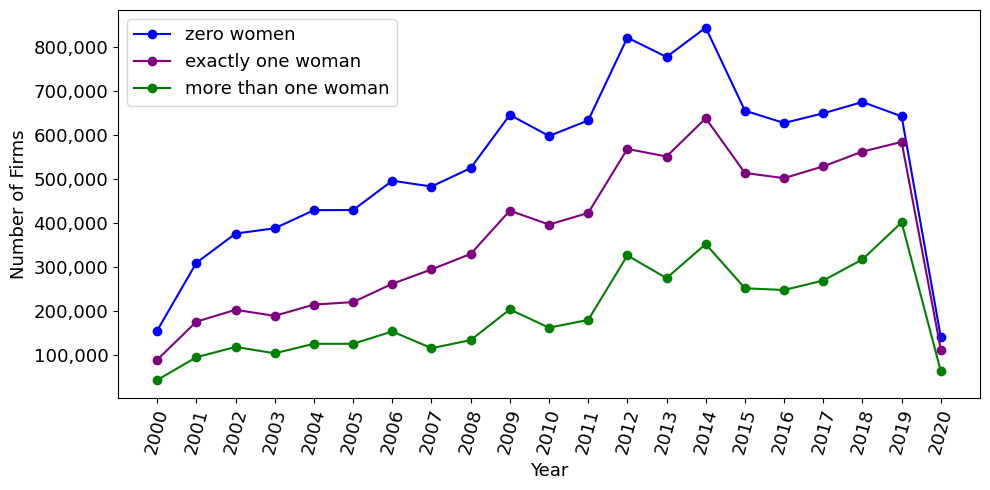

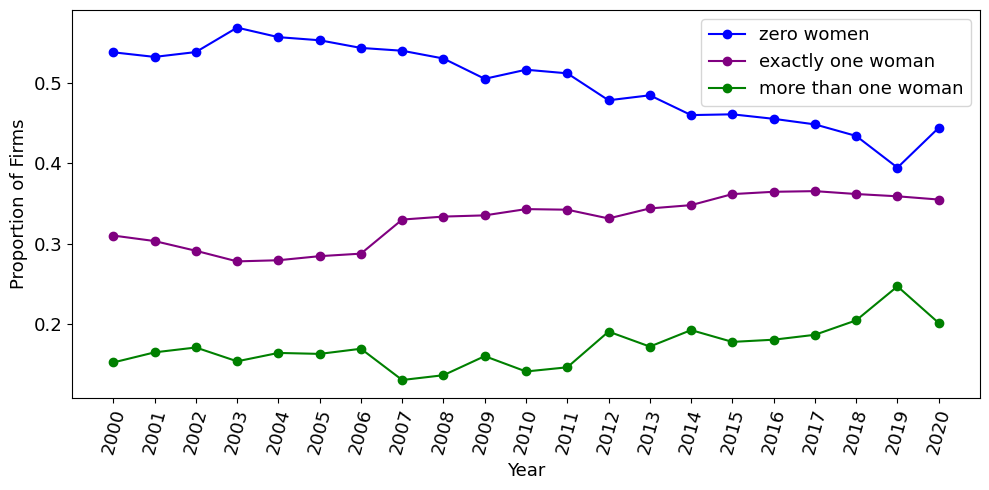

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) Load or prepare your DataFrame
# Replace this simulated data with your real df:
# df = pd.read_csv("your_data.csv", parse_dates=["date"])

years = list(range(2000, 2020))

def categorize(count):
    if count == 0:
        return "zero women"
    elif count == 1:
        return "exactly one woman"
    else: #count > 1:
        return "more than one woman"
    
dfr23["category"] = dfr23["W"].apply(categorize)

# 4) Aggregate raw counts by date and category
raw_counts = (
    dfr23
    .groupby(["year", "category"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

categories = ["zero women", "exactly one woman", "more than one woman"]
colors     = ["blue", "purple",       "green"]  # must correspond 1:1

def y_tick_formatter(value, pos):
    return f"{int(value):,}"

# 5) Compute proportions
prop_counts = raw_counts.div(raw_counts.sum(axis=1), axis=0)

######################
# Build an array of years for x-axis
years = raw_counts.index.to_list()

# If you want custom x-ticks (e.g. every year):
xticks = years  # or you could filter if you only want some years


# ─── 5) Plot #1: Raw Counts ────────────────────────────────────────────────────
plt.figure(figsize=(10, 5))

ax1 = plt.gca()
ax1.yaxis.set_major_formatter(FuncFormatter(y_tick_formatter))

for cat, col in zip(categories, colors):
    # If for some reason a category is missing in raw_counts, fill 0
    series = raw_counts.get(cat, pd.Series(0, index=years))
    plt.plot(
        years,
        series.values,
        marker="o",
        color=col,
        label=cat
    )

plt.xlabel("Year", fontsize=13)
plt.ylabel("Number of Firms", fontsize=13)
#plt.title("Raw Number of Firms by Women‐Count Category", fontsize=16)
plt.xticks(xticks, rotation=75, fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)
plt.tight_layout()


plt.savefig(os.path.join(SAVE_DIRECTORY, "012numbers.png"), dpi=300)
plt.show()


# ─── 6) Plot #2: Proportions ───────────────────────────────────────────────────
plt.figure(figsize=(10, 5))

for cat, col in zip(categories, colors):
    series = prop_counts.get(cat, pd.Series(0, index=years))
    plt.plot(
        years,
        series.values,
        marker="o",
        color=col,
        label=cat
    )

plt.xlabel("Year", fontsize=13)
plt.ylabel("Proportion of Firms", fontsize=13)
#plt.title("Proportion of Firms by Women‐Count Category", fontsize=16)
plt.xticks(xticks, rotation=75, fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)
plt.tight_layout()

plt.savefig(os.path.join(SAVE_DIRECTORY, "012shares.png"), dpi=300)
plt.show()


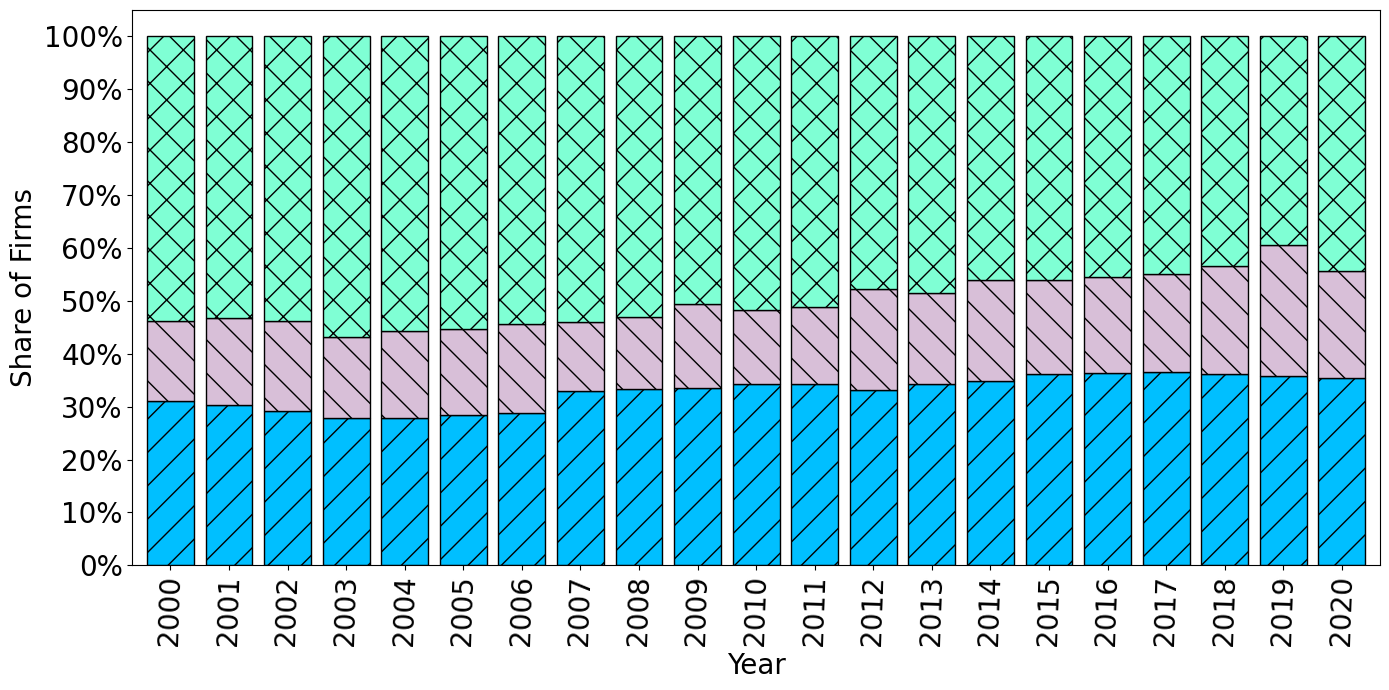

In [19]:
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as mtick

# Create a bigger figure
fig, ax = plt.subplots(figsize=(14, 7))

# Plot with wider bars
prop_counts.plot(
    kind="bar",
    stacked=True,
    width=0.8,        # increase (max is 1.0) to make the bars wider
    edgecolor="black",
    ax=ax,
    color=["deepskyblue", "thistle", "aquamarine"]
)

# Define hatches for each category (must match the order)
hatches = ['/', '\\', 'x']

# Apply hatches to each stacked segment
for hatch, container in zip(hatches, ax.containers):
    for patch in container:
        patch.set_hatch(hatch)

# Labeling
ax.set_xlabel("Year", fontsize=20)
ax.set_ylabel("Share of Firms", fontsize=20)

# Format y-axis as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

# **Set ticks every 10%**
ax.yaxis.set_major_locator(MultipleLocator(0.1))

# Legend outside
#ax.legend(title="Category", loc="upper left", bbox_to_anchor=(1, 1), fontsize=16)
ax.get_legend().remove()

# Ticks
plt.xticks(rotation=88, fontsize=20) #75
plt.yticks(fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIRECTORY, "012stack.png"), dpi=300)
plt.show()

In [ ]:
def extract_ps_simple(
    df: pd.DataFrame,
    group_vars: list | str,
    board: str = "total",
    external_ps: str | None = None
) -> dict[str, pd.DataFrame]:
    """
    If `external_ps` is provided (and exists in `df`), this function:
      • Groups by `group_vars`
      • Computes ps_ext = mean(external_ps) / 100 for each group
      • Returns that as pd.DataFrame under key 'external'

    If `external_ps` is None (or not in df.columns), it falls back to:
      • Grouping by `group_vars`
      • Summing {board}_fem and {board}_male per group
      • Computing ps_calc = sum_fem / (sum_fem + sum_male)
      • Returning that under key 'calculated'

    Returns a dictionary with exactly two keys:
      { 'calculated': DataFrame (may be empty),
        'external':   DataFrame (may be empty) }
    """
    if isinstance(group_vars, str):
        group_vars = [group_vars]

    # CASE A: external_ps path
    if external_ps is not None and external_ps in df.columns:
        missing = [g for g in group_vars if g not in df.columns]
        if missing:
            raise KeyError(f"Missing grouping columns: {missing}")

        # Group by and compute mean(external_ps)/100
        # We want exactly one row per unique combination of group_vars.
        grouped_ext = (
            df
            .groupby(group_vars)[external_ps]
            .mean()
            .div(100)  # normalize percentage to fraction
            .reset_index(name="ps")
        )
        return {"calculated": pd.DataFrame(), "external": grouped_ext}

    # CASE B: board‐based calculation (fallback)
    fem_col = f"{board}_fem"
    male_col = f"{board}_male"
    if fem_col not in df.columns or male_col not in df.columns:
        raise KeyError(
            f"Neither '{external_ps}' nor both '{fem_col}'/'{male_col}' "
            "columns found. Cannot compute ps."
        )

    # Group by group_vars and compute ps = sum(fem) / (sum(fem) + sum(male))
    calc_rows = []
    for name, group in df.groupby(group_vars):
        if isinstance(name, tuple):
            grp_dict = dict(zip(group_vars, name))
        else:
            grp_dict = {group_vars[0]: name}

        fem_total = group[fem_col].sum()
        male_total = group[male_col].sum()
        if (fem_total + male_total) > 0:
            grp_dict["ps"] = fem_total / (fem_total + male_total)
        else:
            grp_dict["ps"] = pd.NA

        calc_rows.append(grp_dict)

    calculated_df = pd.DataFrame(calc_rows)
    return {"calculated": calculated_df, "external": pd.DataFrame()}

# COUNTRY YEAR
ps23 = extract_ps_simple(dfr23, group_vars=['year', 'country'], board='total', external_ps=None)
ts23 = extract_ps_simple(takers23, group_vars=['year', 'country'], board='total', external_ps=None)
ilostat = extract_ps_simple(dfr23, group_vars=['year', 'country'], board='total', external_ps='obs_value')
sesstat = extract_ps_simple(df_ses14_cy, group_vars=['year', 'country'], board='total', external_ps='obs_value')

# COUNTRY YEAR SECTOR
ps23_ = extract_ps_simple(dfr23, group_vars=['year', 'country', 'group'], board='total', external_ps=None)
ts23_ = extract_ps_simple(takers23, group_vars=['year', 'country', 'group'], board='total', external_ps=None)
ses14 = extract_ps_simple(df_ses14, group_vars=['year', 'country', 'group'], board='total', external_ps='fem_managers1d')

In [21]:
def compute_ps_correlation(
    ps_result_a: dict[str, pd.DataFrame],
    which_a: str,
    ps_result_b: dict[str, pd.DataFrame],
    which_b: str,
    merge_keys: list[str]
) -> pd.DataFrame:
    """
    Given two outputs from extract_ps_simple (each a dict with keys 'calculated' and/or 'external'),
    pick the specified DataFrame (which_a, which_b), merge them on merge_keys, drop NaNs, and
    compute Spearman's rho & p-value.

    Returns a 1-row DataFrame with columns:
      - merge_on       : a tuple of merge_keys
      - source_a       : which_a
      - source_b       : which_b
      - spearman_rho   : correlation coefficient
      - p_value        : p-value
      - n_obs          : number of matched rows (after dropping NaNs)
    """
    # 1) Extract the two DataFrames by the names which_a / which_b
    df_a = ps_result_a.get(which_a, pd.DataFrame()).copy()
    df_b = ps_result_b.get(which_b, pd.DataFrame()).copy()

    if df_a.empty:
        raise ValueError(f"'{which_a}' is empty in the first result dict.")
    if df_b.empty:
        raise ValueError(f"'{which_b}' is empty in the second result dict.")

    # 2) Rename their `ps` columns to avoid collision
    df_a = df_a.rename(columns={"ps": "ps_a"})
    df_b = df_b.rename(columns={"ps": "ps_b"})

    # 3) Merge on the given keys (inner join to keep only matching groups)
    merged = pd.merge(df_a, df_b, on=merge_keys, how="inner")

    # 4) Drop any rows where either ps_a or ps_b is NaN
    merged_clean = merged.dropna(subset=["ps_a", "ps_b"])
    n_obs = len(merged_clean)

    # 5) If fewer than 2 observations, Spearman cannot be computed
    if n_obs < 2:
        rho, pval = float("nan"), float("nan")
    else:
        rho, pval = stats.spearmanr(merged_clean["ps_a"], merged_clean["ps_b"])

    # 6) Build a 1-row summary DataFrame
    summary = pd.DataFrame([{
        "merge_keys": tuple(merge_keys),
        "source_a": which_a,
        "source_b": which_b,
        "spearman_rho": rho,
        "p_value": pval,
        "n_obs": n_obs
    }])

    return summary

In [ ]:
comparisons = [
    # (label,               dictA,   whichA,    dictB,   whichB,       merge_keys)

    # Country × Year comparisons:
    ("ps23 vs ts23 (Yr×Ct)",  ps23,   "calculated", ts23,   "calculated", ["year","country"]),
    ("ps23 vs ilostat (Yr×Ct)",  ps23,   "calculated", ilostat, "external",   ["year","country"]),
    ("ts23 vs ilostat (Yr×Ct)",  ts23,   "calculated", ilostat, "external",   ["year","country"]),
    ("sesstat vs ilostat (Yr×Ct)",  sesstat,   "external", ilostat, "external",   ["year","country"]),

    # Country × Year × Sector comparisons:
    ("ps23_ vs ts23_ (Yr×Ct×S)", ps23_,  "calculated", ts23_,  "calculated", ["year","country","group"]),
    ("ps23_ vs ses14 (Yr×Ct×S)", ps23_,  "calculated", ses14,  "external",   ["year","country","group"]),
    ("ts23_ vs ses14 (Yr×Ct×S)", ts23_,  "calculated", ses14,  "external",   ["year","country","group"])
]

# 3) Loop over each comparison, compute correlation, and concatenate results
all_summaries = []
for label, dict_a, key_a, dict_b, key_b, mk in comparisons:
    try:
        summary_df = compute_ps_correlation(dict_a, key_a, dict_b, key_b, mk)
        summary_df.insert(0, "comparison", label)
        all_summaries.append(summary_df)
    except Exception as e:
        # If something goes wrong (e.g. empty DataFrame), record the error in place of a numeric result
        all_summaries.append(pd.DataFrame([{
            "comparison": label,
            "merge_keys": tuple(mk),
            "source_a": key_a,
            "source_b": key_b,
            "spearman_rho": float("nan"),
            "p_value": float("nan"),
            "n_obs": 0,
            "error": str(e)
        }]))

# 4) Combine all summaries into one DataFrame
final_correlation_summary = pd.concat(all_summaries, ignore_index=True)

# 5) View or save
print(final_correlation_summary)

                   comparison                merge_keys    source_a  \
0        ps23 vs ts23 (Yr×Ct)           (year, country)  calculated   
1     ps23 vs ilostat (Yr×Ct)           (year, country)  calculated   
2     ts23 vs ilostat (Yr×Ct)           (year, country)  calculated   
3  sesstat vs ilostat (Yr×Ct)           (year, country)    external   
4    ps23_ vs ts23_ (Yr×Ct×S)  (year, country, mainsec)  calculated   
5    ps23_ vs ses14 (Yr×Ct×S)  (year, country, mainsec)  calculated   
6    ts23_ vs ses14 (Yr×Ct×S)  (year, country, mainsec)  calculated   

     source_b  spearman_rho        p_value  n_obs  
0  calculated      0.857951  2.290461e-140    480  
1    external      0.461097   1.051740e-24    443  
2    external      0.336048   3.720396e-13    443  
3    external      0.823529   4.857553e-05     17  
4  calculated      0.891876   0.000000e+00   7884  
5    external      0.653210   7.050662e-38    300  
6    external      0.625089   6.342627e-34    300  


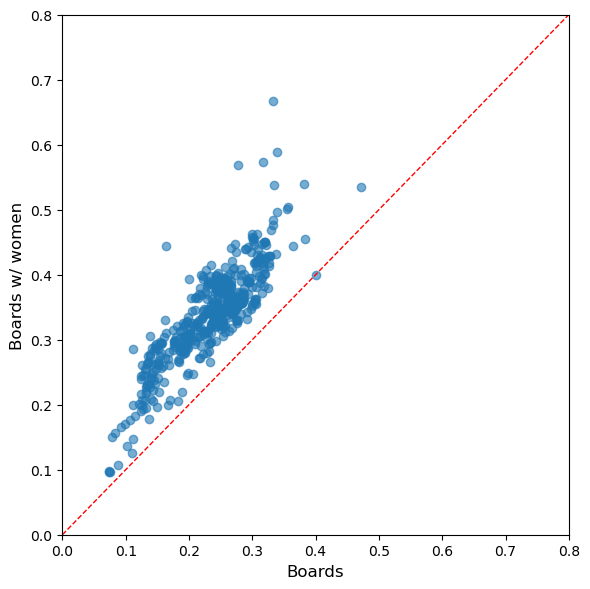

✔ Saved: ..\output\ps23_vs_ts23_YrCt.png  (n=480)


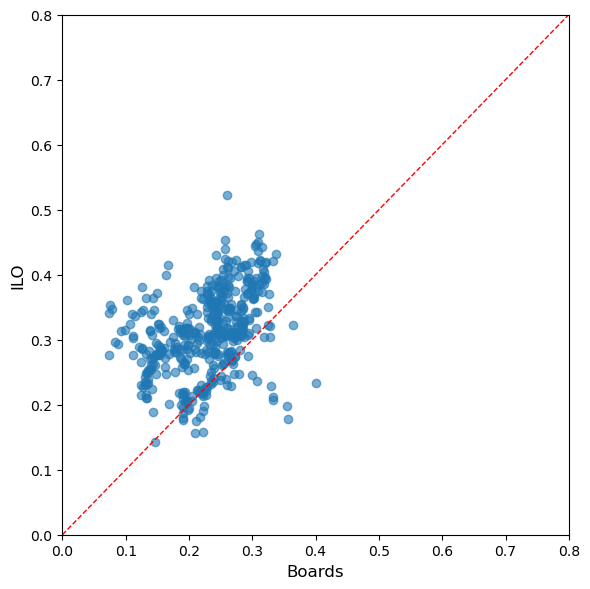

✔ Saved: ..\output\ps23_vs_ilostat_YrCt.png  (n=443)


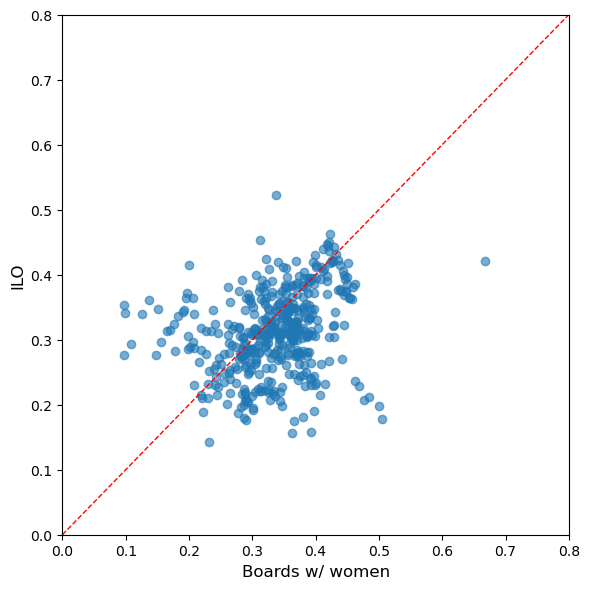

✔ Saved: ..\output\ts23_vs_ilostat_YrCt.png  (n=443)


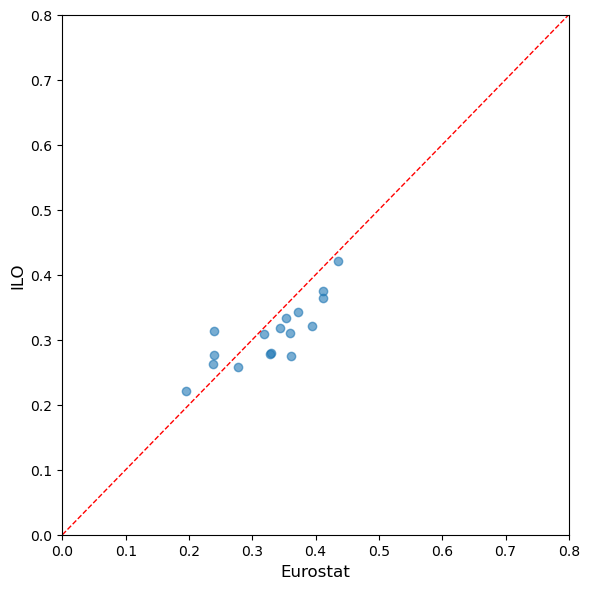

✔ Saved: ..\output\ses14_vs_ilostat_YrCt.png  (n=17)


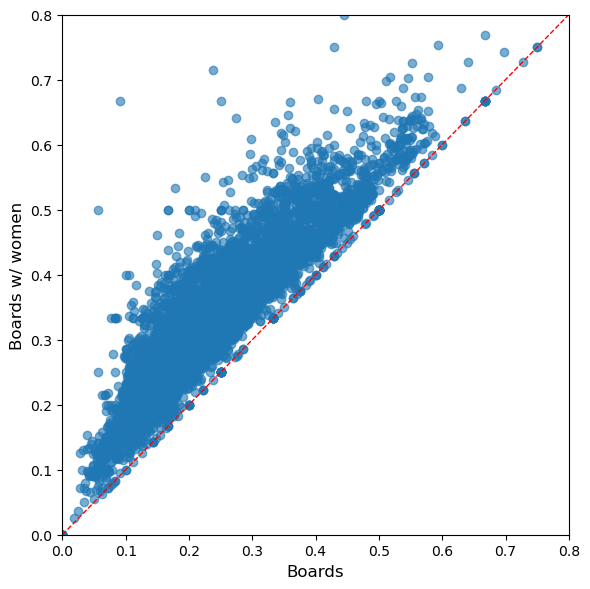

✔ Saved: ..\output\ps23_vs_ts23_YrCtSec.png  (n=7884)


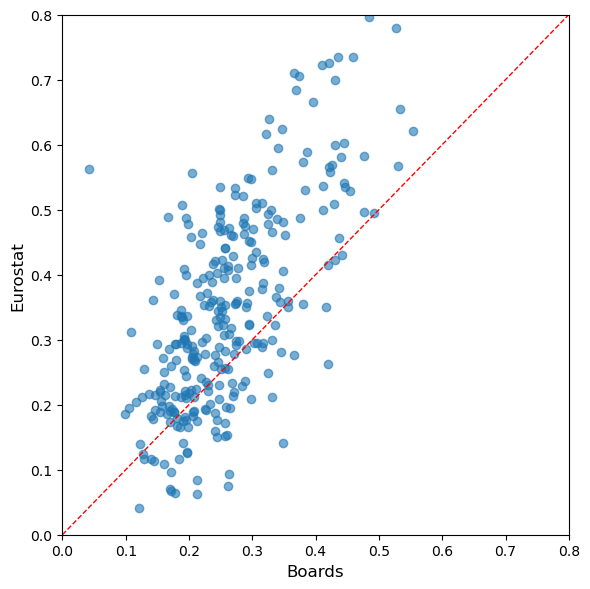

✔ Saved: ..\output\ps23_vs_ses14_YrCtSec.png  (n=300)


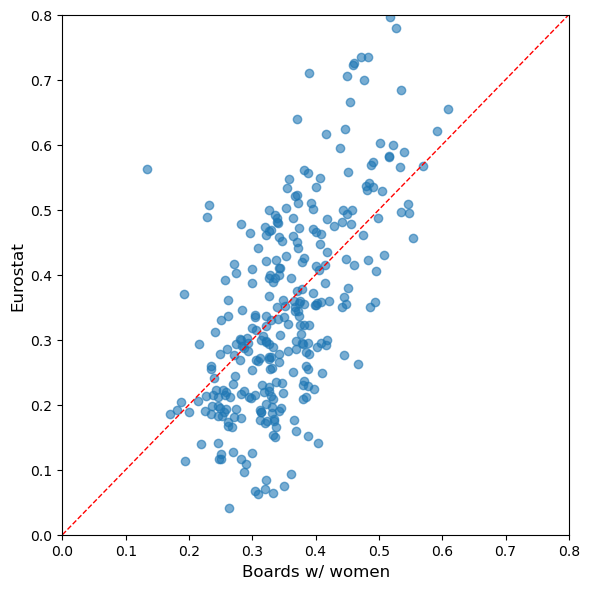

✔ Saved: ..\output\ts23_vs_ses14_YrCtSec.png  (n=300)


In [ ]:
def plot_ps_pairs(pairs_to_plot, output_dir, dpi=300):
    """
    For each tuple in pairs_to_plot:
      ( dictA, keyA, dictB, keyB, merge_keys, filename_stub )
    - Merge dictA[keyA] and dictB[keyB] on merge_keys
    - Drop any rows where either `ps` is NaN
    - Plot a 0..0.8 scatter of ps_A vs ps_B, with a red dashed y=x line
    - Label axes using a small label_map
    - Save to output_dir/filename_stub.png

    filename_stub is expected to look like "ps23_vs_ts23_YrCt" or "ps23_vs_ses14_YrCtSec", etc.
    """
    os.makedirs(output_dir, exist_ok=True)

    # A dictionary to give nicer axis labels for each short code
    label_map = {
        'ps23':   'total',
        'ts23':   'total w/ women',
        'ilostat':'ILO',
        'ps23_':  'total',
        'ts23_':  'total w/ women',
        'ses14':  'Eurostat'
    }

    for (dictA, keyA, dictB, keyB, merge_keys, filename_stub) in pairs_to_plot:
        # 1) Extract DataFrames
        dfA = dictA.get(keyA, pd.DataFrame()).copy()
        dfB = dictB.get(keyB, pd.DataFrame()).copy()

        if dfA.empty:
            print(f"✘ Skipping {filename_stub}: dictA['{keyA}'] is empty.")
            continue
        if dfB.empty:
            print(f"✘ Skipping {filename_stub}: dictB['{keyB}'] is empty.")
            continue

        # 2) Rename the 'ps' column so they don’t collide
        dfA = dfA.rename(columns={'ps': 'ps_A'})
        dfB = dfB.rename(columns={'ps': 'ps_B'})

        # 3) Merge on the specified keys (inner join)
        merged = pd.merge(dfA, dfB, on=merge_keys, how='inner')

        # 4) Drop rows where either ps_A or ps_B is NaN
        merged_clean = merged.dropna(subset=['ps_A', 'ps_B'])
        n_obs = len(merged_clean)

        if n_obs < 1:
            print(f"✘ No overlapping rows for {filename_stub} after dropping NaNs.")
            continue

        # 5) Plot
        plt.figure(figsize=(6, 6))
        plt.scatter(merged_clean['ps_A'], merged_clean['ps_B'], alpha=0.6)

        # Reference line y=x (from 0.0 to 0.8)
        plt.plot([0.0, 0.8], [0.0, 0.8], 'r--', linewidth=1)

        # Decide axis labels based on filename_stub
        # e.g. "ps23_vs_ts23_YrCt" → left_name="ps23", right_name="ts23_YrCt"
        left_name, right_name = filename_stub.split('_vs_')

        # But label_map keys are just 'ps23' and 'ts23', not 'ts23_YrCt'.
        # So strip off any trailing "_YrCt" or "_YrCtSec" etc. by splitting at "_" once.
        left_key  = left_name.split('_')[0]
        right_key = right_name.split('_')[0]

        xlabel = label_map.get(left_key, left_key)
        ylabel = label_map.get(right_key, right_key)

        plt.xlabel(f"{xlabel}", fontsize=12)
        plt.ylabel(f"{ylabel}", fontsize=12)
#        plt.title(f"n={n_obs}", fontsize=10)

        plt.xlim(0.0, 0.8)
        plt.ylim(0.0, 0.8)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()

        # 6) Save
        outpath = os.path.join(output_dir, f"{filename_stub}.png")
        plt.savefig(outpath, dpi=dpi)
        plt.show()
        plt.close()

        print(f"✔ Saved: {outpath}  (n={n_obs})")

pairs_to_plot = [
    # COUNTRY × YEAR (no sector):
    (ps23,    'calculated', ts23,    'calculated', ['year','country'],             'ps23_vs_ts23_YrCt'),
    (ps23,    'calculated', ilostat, 'external',   ['year','country'],             'ps23_vs_ilostat_YrCt'),
    (ts23,    'calculated', ilostat, 'external',   ['year','country'],             'ts23_vs_ilostat_YrCt'),
    (sesstat,    'external', ilostat, 'external',   ['year','country'],           'ses14_vs_ilostat_YrCt'),

    # COUNTRY × YEAR × SECTOR:
    (ps23_,   'calculated', ts23_,   'calculated', ['year','country','group'],  'ps23_vs_ts23_YrCtSec'),
    (ps23_,   'calculated', ses14,   'external',   ['year','country','group'],  'ps23_vs_ses14_YrCtSec'),
    (ts23_,   'calculated', ses14,   'external',   ['year','country','group'],  'ts23_vs_ses14_YrCtSec'),
]

# Finally, call the function:
plot_ps_pairs(pairs_to_plot, output_dir=SAVE_DIRECTORY, dpi=300)

### Tests

In [ ]:
import os
from typing import Dict, Iterable, List, Optional, Sequence, Tuple

import pandas as pd

# Package imports
from implicitquotas import analysis as iq
from implicitquotas import core as iqc
from implicitquotas import plotting as iqp

In [ ]:
# ---------- column inference & validation --------------------------------------
def _infer_id_col(df: pd.DataFrame,
                  candidates: Sequence[str] = ("id_bvd", "bvdidnumber", "firm_id", "id")
                 ) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"Could not infer an ID column. Tried: {list(candidates)}")

def _gender_cols_from_board(df: pd.DataFrame, board: str) -> Tuple[str, str]:
    fem = f"{board}_fem"
    male = f"{board}_male"
    missing = [c for c in (fem, male) if c not in df.columns]
    if missing:
        raise KeyError(f"Missing gender count columns for board='{board}': {missing}")
    return fem, male


# ---------- option handling (replicates your original skip rules when desired) --
def _should_skip_combo(group_vars: Sequence[str],
                       calc_before: bool,
                       external_ps_col: Optional[str],
                       strict_obs_value_rules: bool
                      ) -> bool:
    """
    If False -> never skip based on 'obs_value'.
    """
    if not strict_obs_value_rules:
        return False
    if external_ps_col != "obs_value":
        return False
    if list(group_vars) != ["country", "year"]:
        return True
    if not calc_before:
        return True
    return False


# ---------- pretty label helpers ------------------------------------------------
def _label_none(x: Optional[str]) -> str:
    return str(x) if x else "none"


In [ ]:
def run_grid_experiments(
    *,
    dataset_configs: Sequence[Tuple[str, pd.DataFrame, int]],
    group_vars_list: Sequence[Sequence[str]],
    calc_before_options: Iterable[bool],
    external_ps_options: Iterable[Optional[str]],
    board: str,
    save_dir: str,
    panel: bool,
    min_group_size: int = 10,
    n_jobs_fn = lambda agg: agg + 1,
    strict_obs_value_rules: bool = True,   # set to False for the “SES/obs_value with mainsec” runs
    id_col: Optional[str] = None
) -> Dict[Tuple, pd.DataFrame]:
    """
    Runs your cross-product of configs using the package APIs.

    Returns
    -------
    dict keyed by:
      (data_name, "all", tuple(group_vars), calc_before, external_ps_col, agg)
    """
    os.makedirs(save_dir, exist_ok=True)
    all_results: Dict[Tuple, pd.DataFrame] = {}

    for data_name, data_df, agg_value in dataset_configs:
        df_sub = data_df.copy()

        # infer columns (once per dataset)
        fem_col, male_col = _gender_cols_from_board(df_sub, board)
        id_col_eff = id_col or _infer_id_col(df_sub)

        for group_vars in group_vars_list:
            for calc_before in calc_before_options:
                for external_ps_col in external_ps_options:
                    # normalize choices: only 'ps' or 'obs_value' survive; None means compute from counts
                    ext_ps = external_ps_col if external_ps_col in {"ps", "obs_value"} else None

                    if _should_skip_combo(group_vars, calc_before, ext_ps, strict_obs_value_rules):
                        continue

                    print(
                        f"Dataset: {data_name}, Subgroup: all, "
                        f"group_vars: {group_vars}, calc_before: {calc_before}, "
                        f"external_ps: {ext_ps}, agg: {agg_value}"
                    )

                    # 1) p_s (Series) via the package
                    p_s = iq.build_p_s(
                        df=df_sub,
                        group_vars=group_vars,
                        female_col=fem_col,
                        male_col=male_col,
                        external_ps_col=ext_ps,            # percent column if not None
                        calculate_ps_before=calc_before,
                        candidate_pool=df_sub if calc_before else None
                    )

                    # 2) analysis
                    try:
                        result_df = iq.perform_analysis(
                            df=df_sub,
                            p_s=p_s,
                            group_vars=group_vars,
                            female_col=fem_col,
                            male_col=male_col,
                            id_col=id_col_eff,
                            agg=agg_value,
                            panel=panel,
                            min_group_size=min_group_size,
                            n_jobs=int(n_jobs_fn(agg_value)),
                        )
                    except Exception as e:
                        print(f"✘ Error ({data_name}, all, {group_vars}, agg={agg_value}): {e}")
                        result_df = pd.DataFrame({"error": [str(e)]})

                    # 3) store + save CSV
                    key = (data_name, "all", tuple(group_vars), calc_before, ext_ps, agg_value)
                    all_results[key] = result_df

                    ext_label   = _label_none(ext_ps)
                    group_label = "-".join(group_vars)
                    filename = (
                        f"{data_name}__all__{group_label}"
                        f"__calc{calc_before}__ext-{ext_label}__agg{agg_value}.csv"
                    )
                    filepath = os.path.join(save_dir, filename)
                    try:
                        result_df.to_csv(filepath, index=False)
                        print(f"  ✓ Saved CSV: {filepath}")
                    except Exception as save_err:
                        print(f"  ✘ Failed to save CSV for {key}: {save_err}")

    return all_results

In [ ]:
# --- 1) country-year & country-year-group; dfr/takers; obs_value rules active
group_vars_list_1 = [
    ["country", "year"],
    ["country", "year", "group"],
]
dataset_configs_1 = [
    ("dfr23",   dfr23,    1),
    ("dfr2",    dfr2,     1),
    ("dfr3",    dfr3,     1),
    ("takers23", takers23, 5),
    ("takers2",  takers2,  5),
    ("takers3",  takers3,  5),
]
results_1 = run_grid_experiments(
    dataset_configs=dataset_configs_1,
    group_vars_list=group_vars_list_1,
    calc_before_options=[True, False],
    external_ps_options=[None, "obs_value", "ps"],
    board="total",
    panel=True,
    save_dir=SAVE_DIRECTORY,
    strict_obs_value_rules=True,   # honors your original skip logic
)

# --- 2) SES, year==2014 subset, ps-or-none, no panel
group_vars_list_2 = [["country", "year", "mainsec"]]
dataset_configs_2 = [("dfr23", dfr23[dfr23.year == 2014], 5)]
results_2 = run_grid_experiments(
    dataset_configs=dataset_configs_2,
    group_vars_list=group_vars_list_2,
    calc_before_options=[True, False],
    external_ps_options=[None, "ps"],
    board="boards",
    panel=False,
    save_dir=SAVE_DIRECTORY,
    strict_obs_value_rules=False,  # you didn't apply the obs_value skip logic here
)

# --- 3) SES, takers23 year==2014, ps-or-none, no panel
dataset_configs_3 = [("takers23", takers23[takers23.year == 2014], 5)]
results_3 = run_grid_experiments(
    dataset_configs=dataset_configs_3,
    group_vars_list=group_vars_list_2,
    calc_before_options=[True, False],
    external_ps_options=[None, "ps"],
    board="boards",
    panel=False,
    save_dir=SAVE_DIRECTORY,
    strict_obs_value_rules=False,
)

# --- 4) SES, takers23 full, obs_value-or-none, calc_before=True
dataset_configs_4 = [("takers23", takers23, 5)]
results_4 = run_grid_experiments(
    dataset_configs=dataset_configs_4,
    group_vars_list=group_vars_list_2,
    calc_before_options=[True],            # just True
    external_ps_options=[None, "obs_value"],
    board="boards",
    panel=False,
    save_dir=SAVE_DIRECTORY,
    strict_obs_value_rules=False,          # you allowed obs_value with mainsec here
)

In [ ]:
import pickle  # only if you want to pickle the results dicts

def run_zoom_experiments(
    *,
    all_group_vars_lists: Sequence[Sequence[Sequence[str]]],
    zoom_vars: Sequence[str],
    data_configs: Sequence[Tuple[str, pd.DataFrame, int]],
    board: str,
    save_dir: str,
    file_prefix_base: str = "",
    external_ps_col: Optional[str] = None,   # e.g. "ps" or None
    calculate_ps_before: bool = True,
    candidate_pool: Optional[pd.DataFrame] = None,
    panel: bool = True,
    min_group_size: int = 10,
    n_jobs_fn = lambda agg: agg + 1,
    adjust_method: str = "HB",               # "HB" (Holm-Bonferroni) or "B"
    id_col: Optional[str] = None,
    do_pickle: bool = True,
    do_plots: bool = True
):
    os.makedirs(save_dir, exist_ok=True)

    for group_vars_list in all_group_vars_lists:
        gvl_flat = "_".join(group_vars_list[0])  # one entry per scenario
        grouping_path = os.path.join(save_dir, f"groupby_{gvl_flat}")
        os.makedirs(grouping_path, exist_ok=True)

        print(f"\n=== Running zoom experiments for group_vars_list = {group_vars_list} ===\n")

        for zoom_var in zoom_vars:
            print(f"--- Zoom variable = {zoom_var} ---")
            zoom_folder = os.path.join(grouping_path, f"zoomby_{zoom_var}")
            os.makedirs(zoom_folder, exist_ok=True)

            for data_name, data_df, agg_value in data_configs:
                print(f"  Dataset: {data_name}, agg = {agg_value}")

                fem_col, male_col = _gender_cols_from_board(data_df, board)
                id_col_eff = id_col or _infer_id_col(data_df)

                try:
                    results_obj = iq.zoom_in_analysis(
                        df                   = data_df,
                        analysis_vars        = [zoom_var],
                        group_vars_list      = group_vars_list,
                        female_col           = fem_col,
                        male_col             = male_col,
                        id_col               = id_col_eff,
                        external_ps_col      = external_ps_col,
                        calculate_ps_before  = calculate_ps_before,
                        candidate_pool       = candidate_pool,
                        agg                  = agg_value,
                        panel                = panel,
                        min_group_size       = min_group_size,
                        n_jobs               = int(n_jobs_fn(agg_value)),
                    )
                except Exception as e:
                    print(f"    ✘ Error in zoom_in_analysis for {data_name}, zoom={zoom_var}: {e}")
                    continue

                # Optional: pickle the raw results dict
                if do_pickle:
                    pkl_filename = f"{file_prefix_base}{data_name}__zoomby_{zoom_var}__{gvl_flat}__agg{agg_value}.pkl"
                    pkl_path     = os.path.join(zoom_folder, pkl_filename)
                    try:
                        with open(pkl_path, "wb") as f:
                            pickle.dump(results_obj, f)
                        print(f"    ✓ Pickle saved: {pkl_path}")
                    except Exception as pe:
                        print(f"    ✘ Failed to pickle {data_name}, zoom={zoom_var}: {pe}")

                # Adjust p-values (dict of DataFrames in -> dict of DataFrames out)
                try:
                    adjusted = iqc.adjust_p_values(results_obj, method=adjust_method)
                except Exception as e_adj:
                    print(f"    ✘ Error in p-value adjustment for {data_name}, zoom={zoom_var}: {e_adj}")
                    continue

                # Plot (one heatmap per detected bucket)
                if do_plots:
                    try:
                        plot_prefix = f"{file_prefix_base}{data_name}__zoomby_{zoom_var}__{gvl_flat}__agg{agg_value}__"
                        iqp.plot_zoomed_results(
                            adjusted,
                            save_dir=zoom_folder,
                            file_prefix=plot_prefix
                        )
                        print(f"    ✓ Plots saved in: {zoom_folder}")
                    except Exception as e_plot:
                        print(f"    ✘ Error plotting for {data_name}, zoom={zoom_var}: {e_plot}")

        print(f"\n=== Finished grouping by {gvl_flat} ===\n")

In [ ]:
all_group_vars_lists = [
    [["country", "year"]],
    [["country", "year", "mainsec"]],
]
zoom_vars = ["year", "mainsec", "country"]
data_configs = [
    ("dfr23",    dfr23,    1),
    ("takers23", takers23, 5),
    ("takers2",  takers2,  5),
    ("takers3",  takers3,  5),
]

run_zoom_experiments(
    all_group_vars_lists = all_group_vars_lists,
    zoom_vars            = zoom_vars,
    data_configs         = data_configs,
    board                = "boards",
    external_ps_col      = None,              # or "ps" if you want to use an external % column
    calculate_ps_before  = True,
    candidate_pool       = None,
    panel                = True,
    save_dir             = SAVE_DIRECTORY,
    file_prefix_base     = "",                # optional prefix for file names
    adjust_method        = "HB",              # matches your script
)